---
title: Predicting IBM Churn with LDA and XGBoost
author: R package build
date: '2021-01-05'
slug: hi-hugo
categories: []
tags: []
subtitle: ''
summary: 'Uncover the factors that lead to employee attrition and explore important questions such as ‘show me a breakdown of distance from home by job role and attrition’ or ‘compare average monthly income by education and attrition’. This is a fictional data set created by IBM data scientists.'
authors: []
lastmod: '2021-09-18T13:33:09-04:00'
featured: no
image:
  caption: ''
  focal_point: ''
  preview_only: no
projects: []
---

# HR Churn Analysis

This is me fiddling around with an employee attrition dataset on my last few days at PNC.

## Description

Uncover the factors that lead to employee attrition and explore important questions such as ‘show me a breakdown of distance from home by job role and attrition’ or ‘compare average monthly income by education and attrition’. This is a fictional data set created by IBM data scientists.


Education
1 'Below College'
2 'College'
3 'Bachelor'
4 'Master'
5 'Doctor'

EnvironmentSatisfaction
1 'Low'
2 'Medium'
3 'High'
4 'Very High'

JobInvolvement
1 'Low'
2 'Medium'
3 'High'
4 'Very High'

JobSatisfaction
1 'Low'
2 'Medium'
3 'High'
4 'Very High'

PerformanceRating
1 'Low'
2 'Good'
3 'Excellent'
4 'Outstanding'


RelationshipSatisfaction
1 'Low'
2 'Medium'
3 'High'
4 'Very High'

WorkLifeBalance
1 'Bad'
2 'Good'
3 'Better'
4 'Best'

## Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns
import sklearn

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'
%load_ext autoreload

## Read in Data

,Age,Attrition,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EmployeeCount,EmployeeNumber,...,RelationshipSatisfaction,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
734,22,No,Travel_Rarely,217,Research & Development,8,1,Life Sciences,1,1019,...,1,80,1,4,3,2,4,3,1,1
949,39,No,Travel_Rarely,524,Research & Development,18,2,Life Sciences,1,1322,...,1,80,0,9,6,3,8,7,1,7
948,30,No,Travel_Rarely,634,Research & Development,17,4,Medical,1,1321,...,4,80,2,9,2,3,9,1,0,8
945,50,No,Travel_Rarely,1322,Research & Development,28,3,Life Sciences,1,1317,...,2,80,0,25,2,3,3,2,1,2
944,28,No,Non-Travel,1476,Research & Development,1,3,Life Sciences,1,1315,...,1,80,3,10,6,3,9,8,7,5


(1470, 35)

Age                          int64
Attrition                   object
BusinessTravel              object
DailyRate                    int64
Department                  object
DistanceFromHome             int64
Education                    int64
EducationField              object
EmployeeCount                int64
EmployeeNumber               int64
EnvironmentSatisfaction      int64
Gender                      object
HourlyRate                   int64
JobInvolvement               int64
JobLevel                     int64
JobRole                     object
JobSatisfaction              int64
MaritalStatus               object
MonthlyIncome                int64
MonthlyRate                  int64
NumCompaniesWorked           int64
Over18                      object
OverTime                    object
PercentSalaryHike            int64
PerformanceRating            int64
RelationshipSatisfaction     int64
StandardHours                int64
StockOptionLevel             int64
TotalWorkingYears   

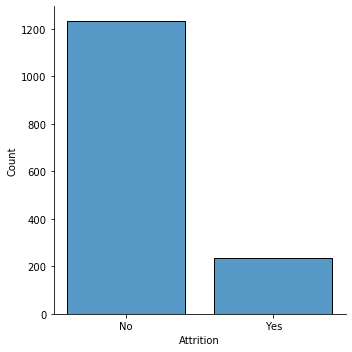

In [2]:
df = pd.read_csv('ibm_attrition_file.csv').sort_values('Attrition')

df.head()
df.shape
df.dtypes

sns.displot(df, x='Attrition', shrink = .8)

## EDA

I first look at some features that might be important in the dataset

### Attrition by Age

Attrition rates are higher among younger employees.

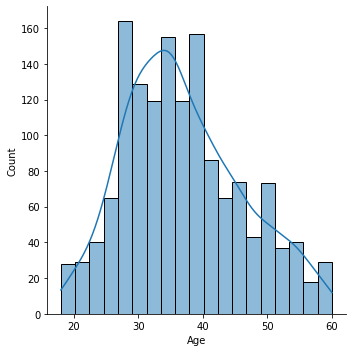

In [3]:
sns.displot(
    df.Age,
    kde = True
)

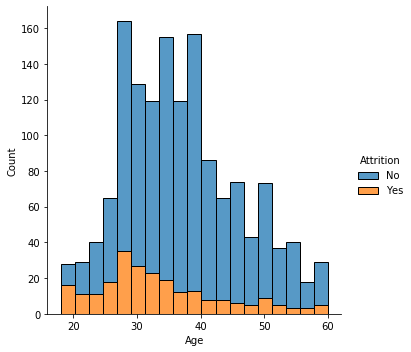

In [4]:
sns.displot(data=df, x="Age", hue="Attrition", multiple="stack")

### Job Satisfaction

Lower job satisfaction unsurprisingly yields a higher attrition rate although perhaps not as high as one might expect.

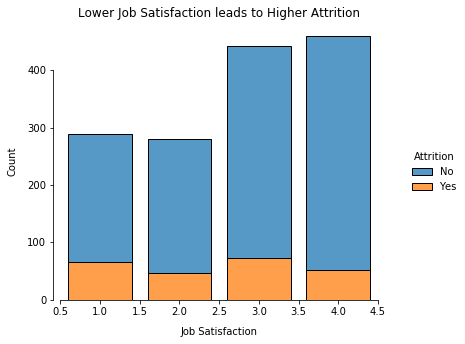

In [6]:
g = sns.displot(
    data = df,
    x = 'JobSatisfaction',
    hue = 'Attrition',
    multiple = 'stack',
    discrete=True,
    shrink = .8
    )

g.set_axis_labels("Job Satisfaction", "Count", labelpad=10)
g.set(title="Lower Job Satisfaction leads to Higher Attrition")
g.fig.set_size_inches(6.5, 4.5)
g.despine(trim=True)

### Gender and Marital Status

Single men and women are more likely to leave the company but age may be a confounder. Men are slightly more likely to leave than women.


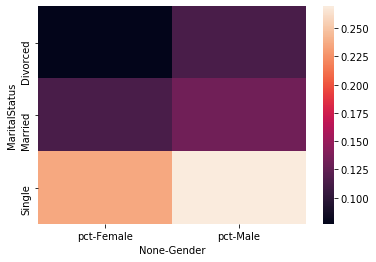

In [7]:
df_new = df.copy()
df_new['Attr'] = df_new['Attrition'].apply(lambda x: 1 if x == 'Yes' else 0)
df_new['Count'] = 1
df_new_group = df_new.groupby(['Gender', 'MaritalStatus'])[['Attr', 'Count']].sum()
df_new_group['pct'] = df_new_group['Attr'] / df_new_group['Count']

df_heat = df_new_group.reset_index()[['Gender','MaritalStatus','pct']]\
    .pivot('MaritalStatus', 'Gender')

sns.heatmap(
    data=df_heat
)

# sns.heatmap(
#     data=df[['Gender', 'MaritalStatus', ]]
#     )

### Correlation Plots

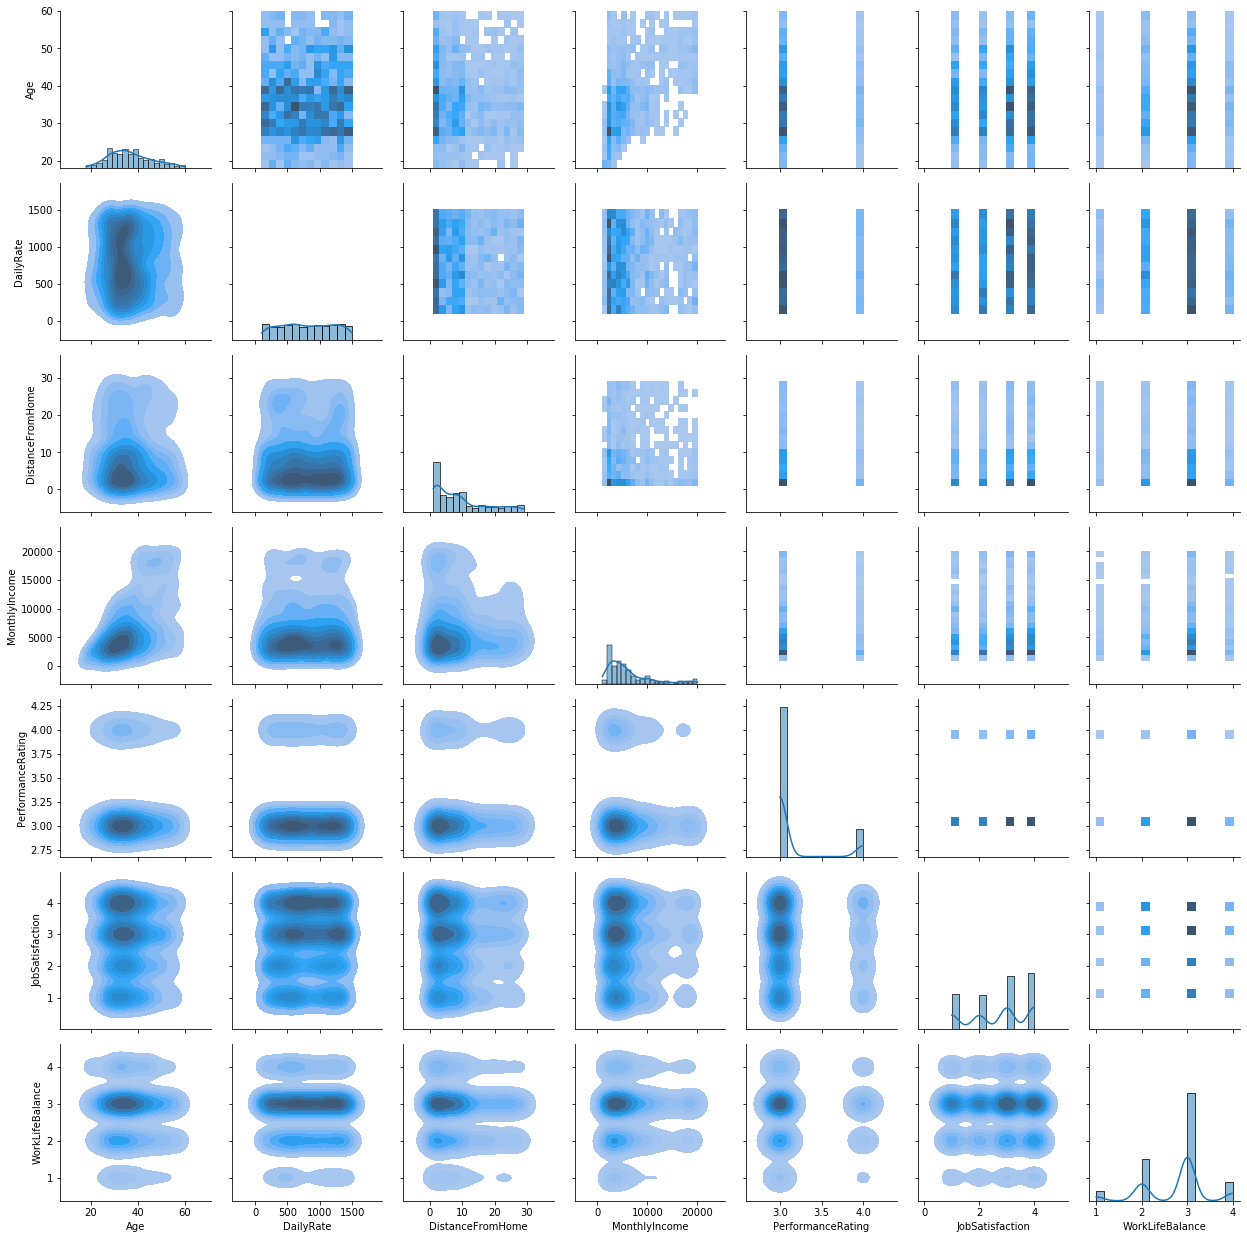

In [8]:
df_num = df[df.columns[df.dtypes == 'int64']][['Age', 'DailyRate', 'DistanceFromHome',\
                                              'MonthlyIncome', 'PerformanceRating', 'JobSatisfaction', \
                                             'WorkLifeBalance']]


g = sns.PairGrid(df_num)
g.map_upper(sns.histplot)
g.map_lower(sns.kdeplot, fill=True)
g.map_diag(sns.histplot, kde=True)

Many features are correlated although no features have a higher correlation than 0.3 or less than -0.1.

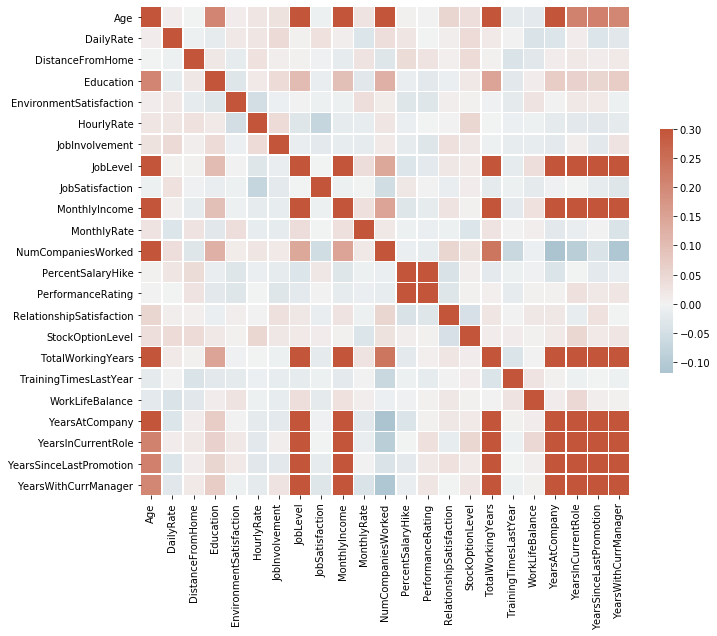

In [9]:
df_heat = df[df.columns[df.dtypes == 'int64']]\
    .drop(['EmployeeCount', 'EmployeeNumber', 'StandardHours'], axis=1)

corr = df_heat.corr()

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr,  cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

## Predictive Analytics - LDA

Linear Discriminant Analysis (LDA) is a feature reduction method for data with discrete classes. It is like PCA except that it takes advantage of information about the classification in the training data. It projects data into fewer dimensions by maximizing both the mean distance between the median data point of each class and minimizing the "spread" within each class.

In [10]:
# Drop columns with no information
df.columns
df_clean = df.drop(['EmployeeCount', 'EmployeeNumber', 'StandardHours', 'Over18'], axis=1)
df_clean['Attrition'] = df_clean['Attrition'].apply(lambda x: 1 if x == 'Yes' else 0)

Index(['Age', 'Attrition', 'BusinessTravel', 'DailyRate', 'Department',
       'DistanceFromHome', 'Education', 'EducationField', 'EmployeeCount',
       'EmployeeNumber', 'EnvironmentSatisfaction', 'Gender', 'HourlyRate',
       'JobInvolvement', 'JobLevel', 'JobRole', 'JobSatisfaction',
       'MaritalStatus', 'MonthlyIncome', 'MonthlyRate', 'NumCompaniesWorked',
       'Over18', 'OverTime', 'PercentSalaryHike', 'PerformanceRating',
       'RelationshipSatisfaction', 'StandardHours', 'StockOptionLevel',
       'TotalWorkingYears', 'TrainingTimesLastYear', 'WorkLifeBalance',
       'YearsAtCompany', 'YearsInCurrentRole', 'YearsSinceLastPromotion',
       'YearsWithCurrManager'],
      dtype='object')

### Encode Features

In [11]:
df_objs = df_clean.columns[df_clean.dtypes == 'object']

df_clean[df_objs]
df_enc = pd.get_dummies(df_clean, prefix = df_objs)
df_enc['Attrition'] = df_clean['Attrition'].apply(lambda x: 'Yes' if x == 1 else 'No')
df_enc.head()

,BusinessTravel,Department,EducationField,Gender,JobRole,MaritalStatus,OverTime
734,Travel_Rarely,Research & Development,Life Sciences,Male,Laboratory Technician,Married,No
949,Travel_Rarely,Research & Development,Life Sciences,Male,Manufacturing Director,Single,No
948,Travel_Rarely,Research & Development,Medical,Female,Manager,Married,Yes
945,Travel_Rarely,Research & Development,Life Sciences,Female,Research Director,Married,Yes
944,Non-Travel,Research & Development,Life Sciences,Female,Laboratory Technician,Married,No
...,...,...,...,...,...,...,...
370,Travel_Rarely,Sales,Life Sciences,Female,Sales Representative,Single,No
1036,Travel_Frequently,Research & Development,Life Sciences,Male,Laboratory Technician,Married,Yes
1033,Travel_Frequently,Research & Development,Life Sciences,Female,Manufacturing Director,Single,No
1057,Travel_Frequently,Sales,Technical Degree,Female,Sales Executive,Single,No


,Age,Attrition,DailyRate,DistanceFromHome,Education,EnvironmentSatisfaction,HourlyRate,JobInvolvement,JobLevel,JobSatisfaction,...,JobRole_Manufacturing Director,JobRole_Research Director,JobRole_Research Scientist,JobRole_Sales Executive,JobRole_Sales Representative,MaritalStatus_Divorced,MaritalStatus_Married,MaritalStatus_Single,OverTime_No,OverTime_Yes
734,22,No,217,8,1,2,94,1,1,1,...,0,0,0,0,0,0,1,0,1,0
949,39,No,524,18,2,1,32,3,2,3,...,1,0,0,0,0,0,0,1,1,0
948,30,No,634,17,4,2,95,3,3,1,...,0,0,0,0,0,0,1,0,0,1
945,50,No,1322,28,3,4,43,3,4,1,...,0,1,0,0,0,0,1,0,0,1
944,28,No,1476,1,3,3,55,1,2,4,...,0,0,0,0,0,0,1,0,1,0


### Split and Normalize Data


In [12]:
import sklearn.preprocessing as sp
import sklearn.model_selection as skms
train, test = skms.train_test_split(df_enc, random_state=42)
trainY, testY = train.Attrition, test.Attrition
trainX, testX = train.drop(['Attrition'], axis=1), test.drop(['Attrition'], axis=1)

df_objs = df_clean.columns[df_clean.dtypes == 'object']

df_clean[df_objs]
df_enc = pd.get_dummies(df_clean, prefix = df_objs)
df_enc.head()

scaler = sp.StandardScaler().fit(trainX)
scale_train = scaler.transform(trainX)
scale_test = scaler.transform(testX)

,BusinessTravel,Department,EducationField,Gender,JobRole,MaritalStatus,OverTime
734,Travel_Rarely,Research & Development,Life Sciences,Male,Laboratory Technician,Married,No
949,Travel_Rarely,Research & Development,Life Sciences,Male,Manufacturing Director,Single,No
948,Travel_Rarely,Research & Development,Medical,Female,Manager,Married,Yes
945,Travel_Rarely,Research & Development,Life Sciences,Female,Research Director,Married,Yes
944,Non-Travel,Research & Development,Life Sciences,Female,Laboratory Technician,Married,No
...,...,...,...,...,...,...,...
370,Travel_Rarely,Sales,Life Sciences,Female,Sales Representative,Single,No
1036,Travel_Frequently,Research & Development,Life Sciences,Male,Laboratory Technician,Married,Yes
1033,Travel_Frequently,Research & Development,Life Sciences,Female,Manufacturing Director,Single,No
1057,Travel_Frequently,Sales,Technical Degree,Female,Sales Executive,Single,No


,Age,Attrition,DailyRate,DistanceFromHome,Education,EnvironmentSatisfaction,HourlyRate,JobInvolvement,JobLevel,JobSatisfaction,...,JobRole_Manufacturing Director,JobRole_Research Director,JobRole_Research Scientist,JobRole_Sales Executive,JobRole_Sales Representative,MaritalStatus_Divorced,MaritalStatus_Married,MaritalStatus_Single,OverTime_No,OverTime_Yes
734,22,0,217,8,1,2,94,1,1,1,...,0,0,0,0,0,0,1,0,1,0
949,39,0,524,18,2,1,32,3,2,3,...,1,0,0,0,0,0,0,1,1,0
948,30,0,634,17,4,2,95,3,3,1,...,0,0,0,0,0,0,1,0,0,1
945,50,0,1322,28,3,4,43,3,4,1,...,0,1,0,0,0,0,1,0,0,1
944,28,0,1476,1,3,3,55,1,2,4,...,0,0,0,0,0,0,1,0,1,0


### Cross Validation Training

In [13]:
import sklearn.discriminant_analysis as sda
import sklearn.metrics as sm

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold

model = sda.LinearDiscriminantAnalysis()

# model.fit(scale_train, trainY)
# define model evaluation method
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=42)
# evaluate model
scores = cross_val_score(model, scale_train, trainY, scoring='accuracy', cv=cv, n_jobs=2)
# summarize result
scores

print('Mean Accuracy: %.3f (%.3f)' % (np.mean(scores), np.std(scores)))

model.fit(scale_train, trainY)

test_preds = model.predict(scale_test)


array([0.84684685, 0.87387387, 0.86363636, 0.88181818, 0.85454545,
       0.89090909, 0.89090909, 0.85454545, 0.90909091, 0.88181818,
       0.86486486, 0.87387387, 0.88181818, 0.88181818, 0.85454545,
       0.81818182, 0.89090909, 0.88181818, 0.86363636, 0.9       ,
       0.91891892, 0.87387387, 0.89090909, 0.85454545, 0.82727273,
       0.88181818, 0.84545455, 0.88181818, 0.89090909, 0.87272727])

Mean Accuracy: 0.873 (0.022)


LinearDiscriminantAnalysis(n_components=None, priors=None, shrinkage=None,
                           solver='svd', store_covariance=False, tol=0.0001)

### Quick evaluation on test set

In [14]:
model = sda.LinearDiscriminantAnalysis()
model.fit(scale_train, trainY)

test_preds = model.predict(scale_test)
sm.confusion_matrix(test_preds, testY)
print(f'Test Accuracy: {round(sm.accuracy_score(test_preds, testY),3)*100}%')

LinearDiscriminantAnalysis(n_components=None, priors=None, shrinkage=None,
                           solver='svd', store_covariance=False, tol=0.0001)

array([[310,  30],
       [  8,  20]])

Test Accuracy: 89.7%


### Extract Feature Importances

In [15]:
lda_features = pd.DataFrame(data={'Feature': trainX.columns, 'Contribution':model.coef_[0], 'abs_cont': np.abs(model.coef_[0])})\
    .sort_values('abs_cont', ascending = False)[['Feature', 'Contribution']]


The test accuracy is actually even higher than the cross validated training accuracy

### Visualize in one dimension

The accuracy is pretty high even reducing everything down to just one dimension which is pretty impressive. I show with some jitter below

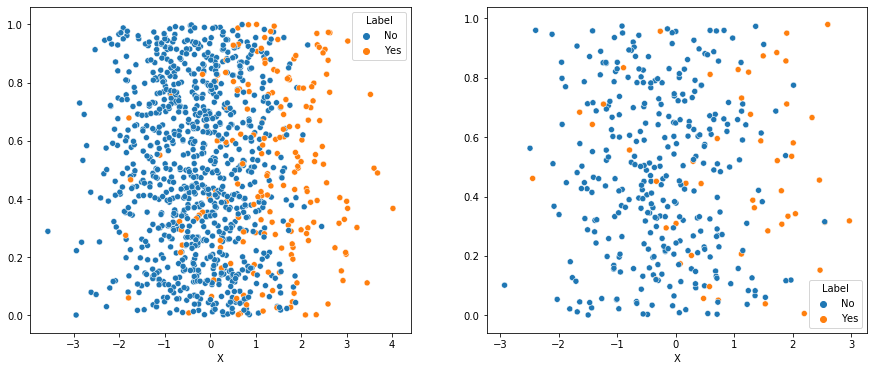

In [16]:
fitted_model = model.fit(scale_train, trainY)

one_d_train = fitted_model.transform(scale_train)
one_d_train = pd.DataFrame(one_d_train, columns = ['X'])
one_d_train['Label'] = trainY.values

jitter = np.random.random(one_d_train.shape[0])

fig, axs = plt.subplots(ncols=2)

fig.set_size_inches(15, 6)
# df['korisnika'].plot(ax=axs[0])
# df['osiguranika'].plot(ax=axs[1])

sns.scatterplot(data=one_d_train, x = 'X', y=jitter,  hue="Label", hue_order = ['No', 'Yes'], ax = axs[0])

one_d_test = fitted_model.transform(scale_test)
one_d_test = pd.DataFrame(one_d_test, columns = ['X'])
one_d_test['Label'] = testY.values

jitter = np.random.random(one_d_test.shape[0])

sns.scatterplot(data=one_d_test, x = 'X', y=jitter,  hue="Label", hue_order = ['No', 'Yes'], ax = axs[1])


### But how does this compare to XGBoost?

In [17]:
from xgboost import XGBClassifier
from xgboost import plot_importance

model = XGBClassifier()
model.fit(trainX, trainY)

train_xgb_preds = model.predict(trainX)
test_xgb_preds = model.predict(testX)

sm.confusion_matrix(train_xgb_preds, trainY)
print(f'Test Accuracy: {round(sm.accuracy_score(train_xgb_preds, trainY),3)*100}%')

sm.confusion_matrix(test_xgb_preds, testY)
print(f'Test Accuracy: {round(sm.accuracy_score(test_xgb_preds, testY),3)*100}%')

/Users/marshallkrassenstein/anaconda3/lib/python3.7/site-packages/xgboost/sklearn.py:892: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].



[19:46:55] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=4, num_parallel_tree=1,
              objective='binary:logistic', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', use_label_encoder=True,
              validate_parameters=1, verbosity=None)

array([[915,   0],
       [  0, 187]])

Test Accuracy: 100.0%


array([[311,  35],
       [  7,  15]])

Test Accuracy: 88.6%


Untrained, XGBoost classifies the training data perfectly but is actually outperformed by LDA on the test data. I suspect a simple grid search would amerliorate this. First, however I want to compare the feature imporance in the two jobs.

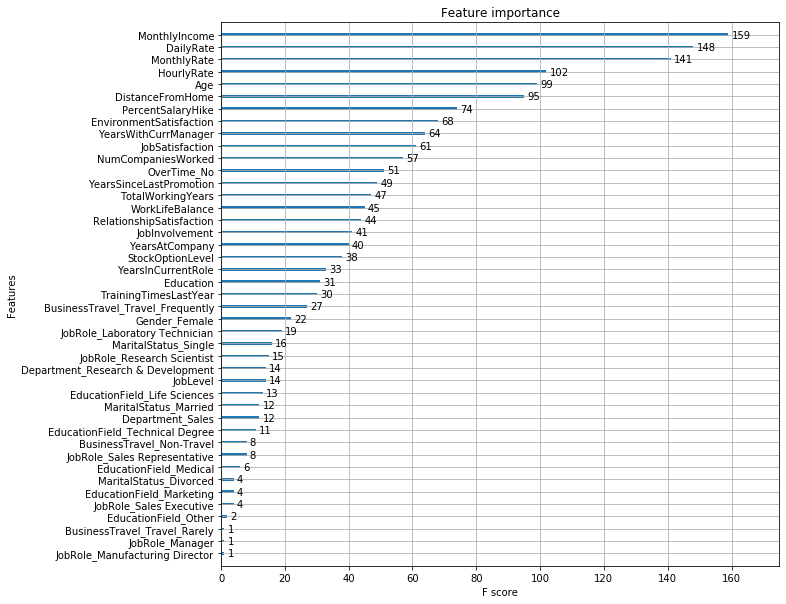

In [18]:
ax = plot_importance(model)
fig = ax.figure
fig.set_size_inches(10, 10)


In [19]:
lda_features

,Feature,Contribution
50,OverTime_Yes,0.507787
49,OverTime_No,-0.507787
4,EnvironmentSatisfaction,-0.491681
45,JobRole_Sales Representative,0.489383
11,NumCompaniesWorked,0.487821
8,JobSatisfaction,-0.445302
6,JobInvolvement,-0.417925
21,YearsSinceLastPromotion,0.389570
16,TotalWorkingYears,-0.380487
22,YearsWithCurrManager,-0.299832


Interestingly LDA has the Monthly and hourly rates as having some of the lowest feature importances while XGBoost has them among the highest